# Code describe the line of reasoning we need to show for all the cases

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, model_selection
from sklearn.metrics import mean_squared_error, r2_score

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load data

In [2]:
B = pd.read_parquet("./data/B_HKML.parquet")

In [3]:
B = B[B["date"] < "2022-05-01"]

In [4]:
X_df = pd.read_parquet("./data/XB_HKML.parquet")
X_df.reset_index(drop=True, inplace=True)

In [5]:
X_df = X_df[X_df["date"] < "2022-05-01"]

In [6]:
y = pd.read_parquet("./data/Y_HKML.parquet")

In [7]:
y = y.iloc[X_df.index]

In [8]:
X = X_df.drop("date", axis=1).to_numpy()

In [9]:
y = y.to_numpy().ravel()

# Train-test split

In [10]:
moons = X_df.date.unique()

In [11]:
moons.shape[0]

307

In [12]:
moon_train = moons[230]
idx_train = X_df[X_df.date < moon_train].index.to_numpy()
idx_train

array([     0,      1,      2, ..., 232749, 232750, 232751])

In [13]:
moon_purge = moons[260]
idx_test = X_df[X_df.date >= moon_purge].index.to_numpy()
idx_test

array([263296, 263297, 263298, ..., 310701, 310702, 310703])

In [14]:
X_train = X[idx_train]
y_train = y[idx_train]

In [15]:
X_test = X[idx_test]
y_test = y[idx_test]

In [16]:
y_test.shape

(47408,)

# Train model and predict

In [17]:
# As this notebook shows a simple linear model, there is no need to introduce validation data, i.e.
# the training is deterministic and only one epoch is necessary to perform it.
# Nevertheless, this section should train such that the validation loss is minimized.

In [18]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [19]:
regr.fit(X_train, y_train)

LinearRegression()

In [20]:
y_hat = regr.predict(X_test)

# Scatter plot to show linear relation between Y and y_hat

In [21]:
from scipy.stats import linregress

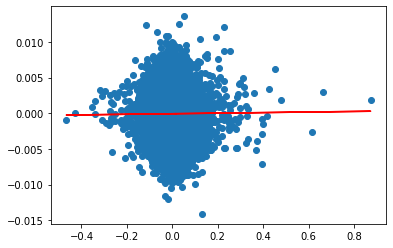

In [22]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_hat)
plt.scatter(y_test, y_hat)
plt.plot(y_test, slope * y_test + intercept, "r")
plt.show()

In [23]:
y_hat_df = pd.DataFrame()
y_hat_df["date"] = X_df[X_df["date"] >= moon_purge].date
y_hat_df["y_hat"] = y_hat
y_hat_df["Y"] = y_test

In [24]:
y_hat_df

,date,y_hat,Y
263296,2021-06-09,-0.002032,0.014321
263297,2021-06-09,0.000152,0.007357
263298,2021-06-09,-0.001883,0.046698
263299,2021-06-09,0.000380,0.017977
263300,2021-06-09,-0.002480,-0.011408
...,...,...,...
310699,2022-04-27,0.000131,0.020271
310700,2022-04-27,0.001777,-0.023498
310701,2022-04-27,-0.002462,0.007559
310702,2022-04-27,0.000751,-0.006418


# Spearman

In [25]:
def spear(x):
    return x.corr(method="spearman").iloc[0, 1]

In [26]:
spearman = y_hat_df.groupby("date").apply(lambda x: spear(x))

/tmp/ipykernel_15703/710519440.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return x.corr(method='spearman').iloc[0, 1]


In [27]:
spearman.mean()

0.0074164642540685425

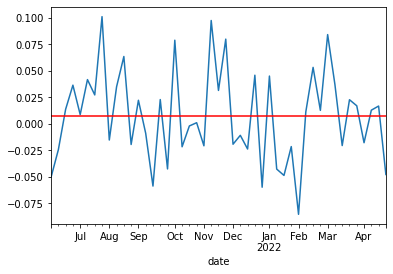

In [28]:
spearman.plot()
plt.axhline(y=spearman.mean(), color="r", linestyle="-")
plt.show()

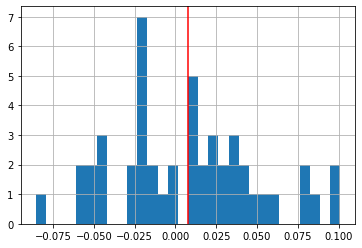

In [29]:
spearman.hist(bins=30)
plt.axvline(x=spearman.mean(), color="r", linestyle="-")

# MSE

In [30]:
mse = y_hat_df.groupby("date").apply(lambda x: mean_squared_error(x.y_hat, x.Y))

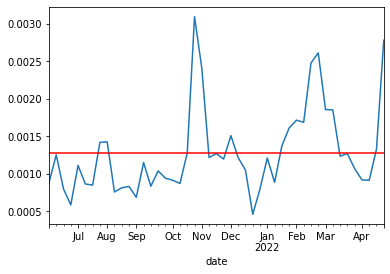

In [31]:
mse.plot()
plt.axhline(y=mse.mean(), color="r", linestyle="-")
plt.show()

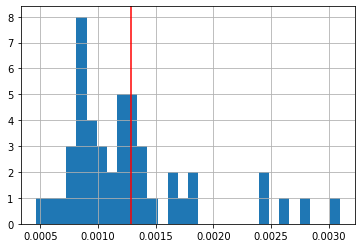

In [32]:
mse.hist(bins=30)
plt.axvline(x=mse.mean(), color="r", linestyle="-")

# Orthogonalize output and show same results.

In [33]:
B = B.iloc[idx_test, :]

In [34]:
y_hat_date = y_hat_df[["date", "y_hat"]]

In [35]:
import sys

sys.path.insert(1, "../feature-engineering/src")
from class_ import Data

In [36]:
data = Data(f_matrix=y_hat_date, b_matrix=B)

In [37]:
data.orthogonalize()

  0%|          | 0/47 [00:00<?, ?it/s]

0

In [38]:
data.f_matrix

,date,y_hat
263296,2021-06-09,-0.002153
263297,2021-06-09,0.000997
263298,2021-06-09,-0.002181
263299,2021-06-09,0.000689
263300,2021-06-09,-0.002264
...,...,...
310699,2022-04-27,0.000008
310700,2022-04-27,0.001744
310701,2022-04-27,-0.002550
310702,2022-04-27,0.001020


In [39]:
y_hat_df.y_hat = data.f_matrix.y_hat

In [40]:
y_hat_df

,date,y_hat,Y
263296,2021-06-09,-0.002153,0.014321
263297,2021-06-09,0.000997,0.007357
263298,2021-06-09,-0.002181,0.046698
263299,2021-06-09,0.000689,0.017977
263300,2021-06-09,-0.002264,-0.011408
...,...,...,...
310699,2022-04-27,0.000008,0.020271
310700,2022-04-27,0.001744,-0.023498
310701,2022-04-27,-0.002550,0.007559
310702,2022-04-27,0.001020,-0.006418


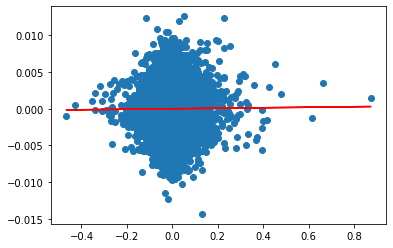

In [41]:
slope, intercept, r_value, p_value, std_err = linregress(y_hat_df.Y, y_hat_df.y_hat)
plt.scatter(y_hat_df.Y, y_hat_df.y_hat)
plt.plot(y_hat_df.Y, slope * y_hat_df.Y + intercept, "r")
plt.show()

In [42]:
spearman.mean()

0.0074164642540685425

/tmp/ipykernel_15703/710519440.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return x.corr(method='spearman').iloc[0, 1]


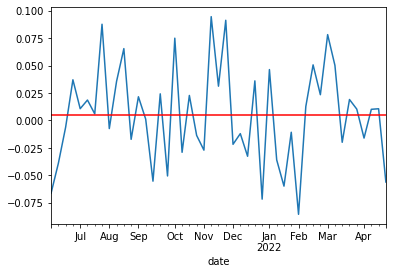

In [43]:
spearman = y_hat_df.groupby("date").apply(lambda x: spear(x))
spearman.plot()
plt.axhline(y=spearman.mean(), color="r", linestyle="-")
plt.show()

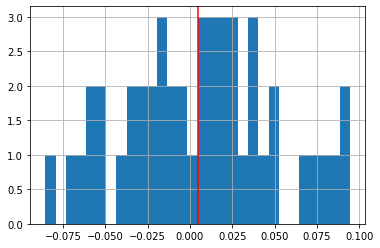

In [44]:
spearman.hist(bins=30)
plt.axvline(x=spearman.mean(), color="r", linestyle="-")

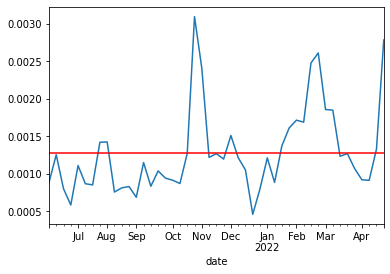

In [45]:
mse = y_hat_df.groupby("date").apply(lambda x: mean_squared_error(x.y_hat, x.Y))
mse.plot()
plt.axhline(y=mse.mean(), color="r", linestyle="-")
plt.show()

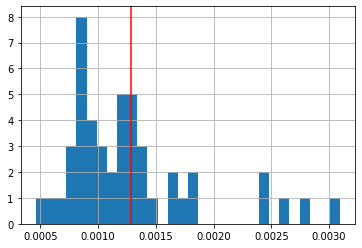

In [46]:
mse.hist(bins=30)
plt.axvline(x=mse.mean(), color="r", linestyle="-")